In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    shuffle=True,
    image_size=(256, 256),
    batch_size=32,
)

Found 4279 files belonging to 8 classes.


In [9]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___bacterial_wilt', 'Potato___healthy', 'Potato___nematode', 'Potato___pests', 'Potato___phytophthora', 'Potato___virus']


In [10]:
len(dataset)


134

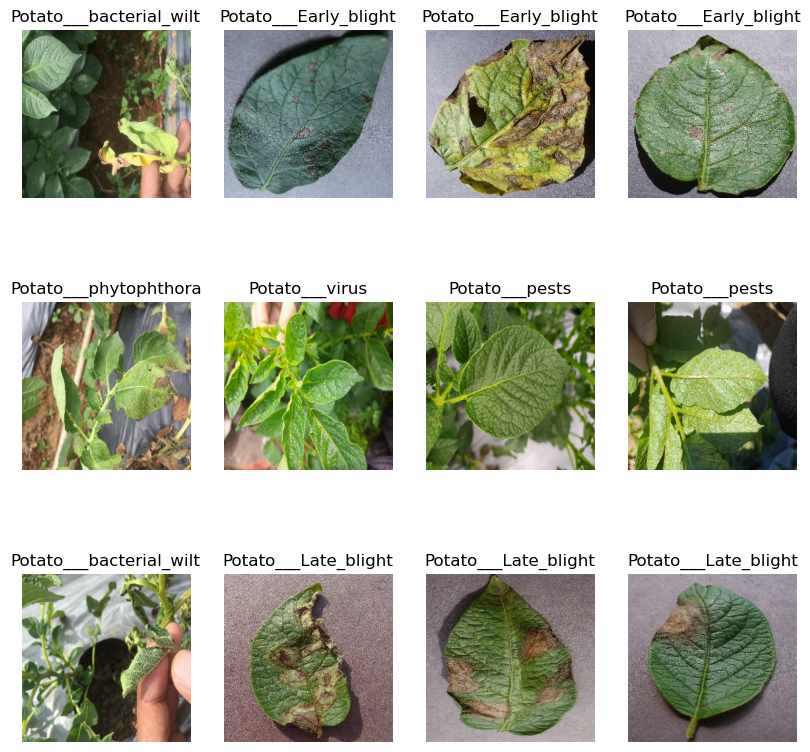

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])



In [12]:
def dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = dataset_partition(dataset)

In [14]:
len(train_ds)

107

In [15]:
len(val_ds)

13

In [16]:
len(test_ds)

14

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(256, 256),
    tf.keras.layers.Rescaling(1.0/255)
])

In [19]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [32]:
input_shape = (32, 256, 256, 3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(8, activation='softmax')
])
model.build(input_shape=input_shape)



In [33]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [34]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [35]:
history = model.fit(train_ds, 
          validation_data=val_ds, 
          epochs=50,
          batch_size=32,
          verbose=1)

Epoch 1/50


107/107 [==============================] - 15s 120ms/step - loss: 1.8537 - accuracy: 0.2673 - val_loss: 1.6017 - val_accuracy: 0.3750
Epoch 2/50
107/107 [==============================] - 13s 120ms/step - loss: 1.5852 - accuracy: 0.3684 - val_loss: 1.3722 - val_accuracy: 0.4832
Epoch 3/50
107/107 [==============================] - 13s 120ms/step - loss: 1.0853 - accuracy: 0.5810 - val_loss: 1.6328 - val_accuracy: 0.5625
Epoch 4/50
107/107 [==============================] - 13s 121ms/step - loss: 0.8314 - accuracy: 0.6820 - val_loss: 0.8462 - val_accuracy: 0.6659
Epoch 5/50
107/107 [==============================] - 13s 121ms/step - loss: 0.7017 - accuracy: 0.7353 - val_loss: 0.9879 - val_accuracy: 0.7019
Epoch 6/50
107/107 [==============================] - 14s 134ms/step - loss: 0.6740 - accuracy: 0.7493 - val_loss: 1.0660 - val_accuracy: 0.6250
Epoch 7/50
107/107 [==============================] - 14s 127ms/step - loss: 0.5861 - accuracy: 0.7833 - val_loss: 0.6653 - val_accuracy: 0.7

In [36]:
scores = model.evaluate(test_ds)


14/14 [==============================] - 1s 31ms/step - loss: 0.4396 - accuracy: 0.8393


In [37]:
history.history['accuracy']



[0.2673499286174774,
 0.3683748245239258,
 0.5809663534164429,
 0.6819912195205688,
 0.7352855205535889,
 0.7493411302566528,
 0.7833089232444763,
 0.7838945984840393,
 0.7961932420730591,
 0.8002928495407104,
 0.8067349791526794,
 0.833674967288971,
 0.8342606425285339,
 0.833089292049408,
 0.8459736704826355,
 0.8445095419883728,
 0.8556368947029114,
 0.8644216656684875,
 0.8553440570831299,
 0.8685212135314941,
 0.8855051398277283,
 0.8767203688621521,
 0.8828697204589844,
 0.8904831409454346,
 0.8837481737136841,
 0.878770112991333,
 0.9021961688995361,
 0.9007320404052734,
 0.8951683640480042,
 0.89341139793396,
 0.8881405591964722,
 0.8986822962760925,
 0.9156661629676819,
 0.8986822962760925,
 0.9168374538421631,
 0.8992679119110107,
 0.9042459726333618,
 0.9183015823364258,
 0.9092240333557129,
 0.9212298393249512,
 0.9308931231498718,
 0.9209370613098145,
 0.913616418838501,
 0.9024890065193176,
 0.9253294467926025,
 0.9241580963134766,
 0.9276720285415649,
 0.9300146698951721

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

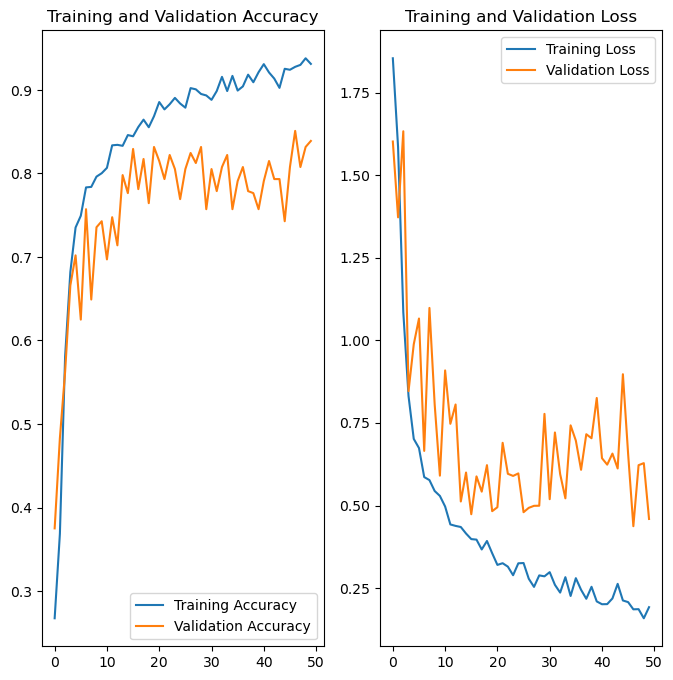

In [39]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


First image to predict
Actual lable:  Potato___Late_blight
1/1 [==============================] - 0s 82ms/step
Predicted lable:  Potato___Late_blight


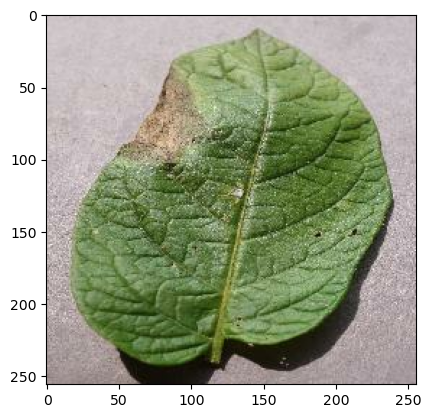

In [40]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype("uint8"))
    first_lable = label_batch[0].numpy()

    print("First image to predict")

    plt.imshow(first_image)
    print("Actual lable: ", class_names[first_lable])
    #print(class_names[first_lable])

    batch_prediction = model.predict(image_batch)
    print("Predicted lable: ", class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 7ms/step


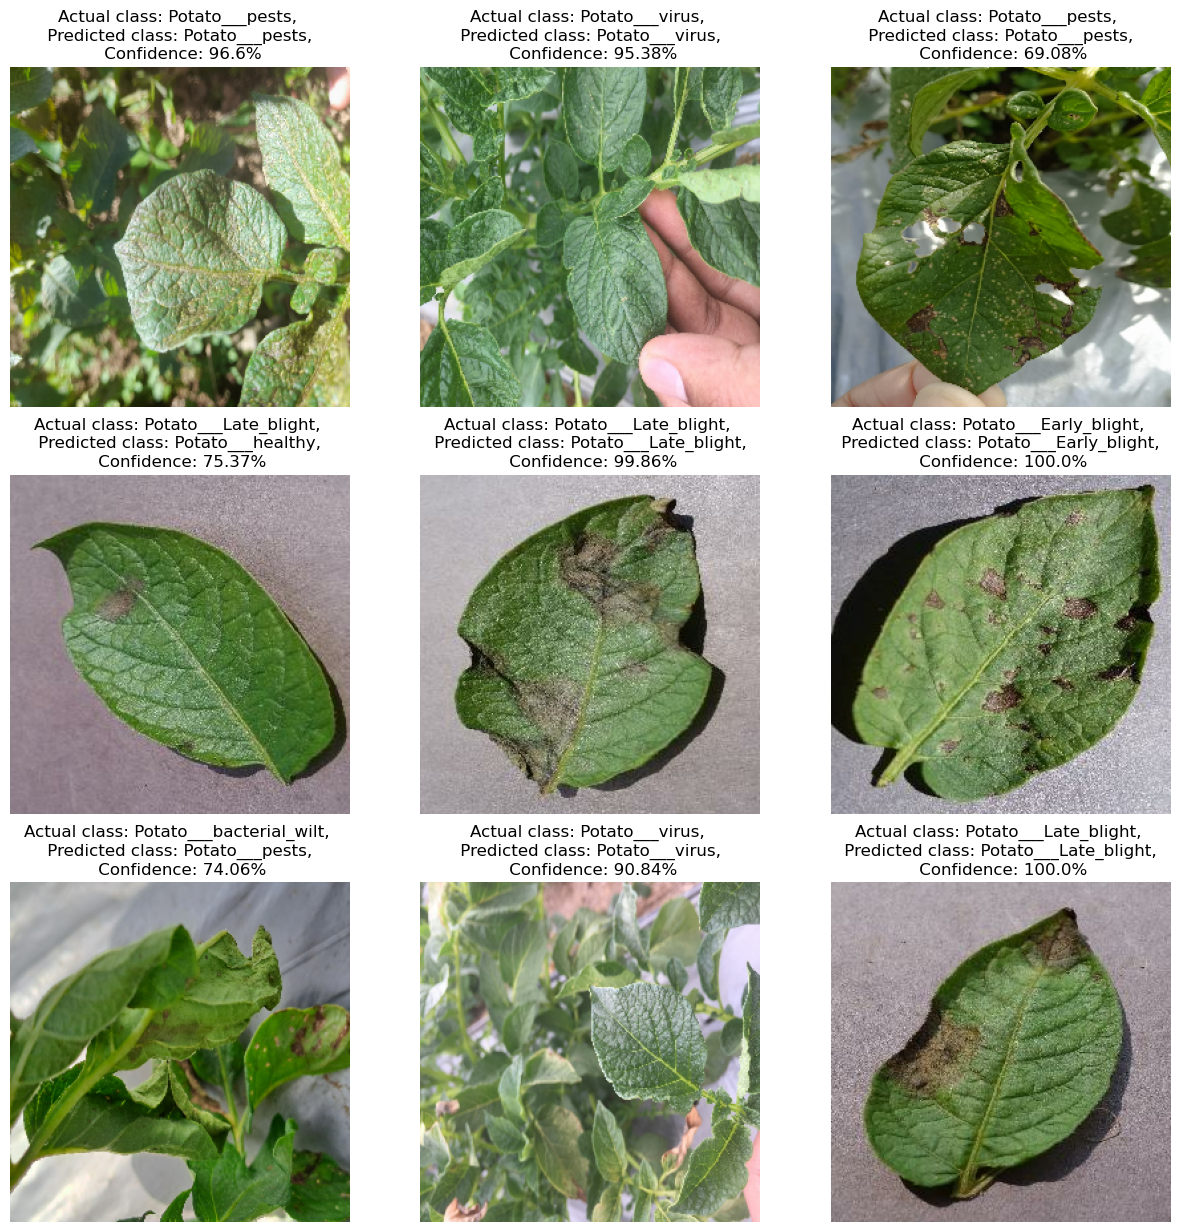

In [42]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]


        plt.title(f"Actual class: {actual_class}, \n Predicted class: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")

In [43]:
model_version = "Potato_Model_v3.00"
model.save(f"../Models/{model_version}")
model.save(f"../Models/{model_version}.h5")



INFO:tensorflow:Assets written to: ../Models/Potato_Model_v3.00\assets


INFO:tensorflow:Assets written to: ../Models/Potato_Model_v3.00\assets
